### Necessary Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import scipy.signal as signal
import librosa
import librosa.display

### Part-I

### Loading the Audio File

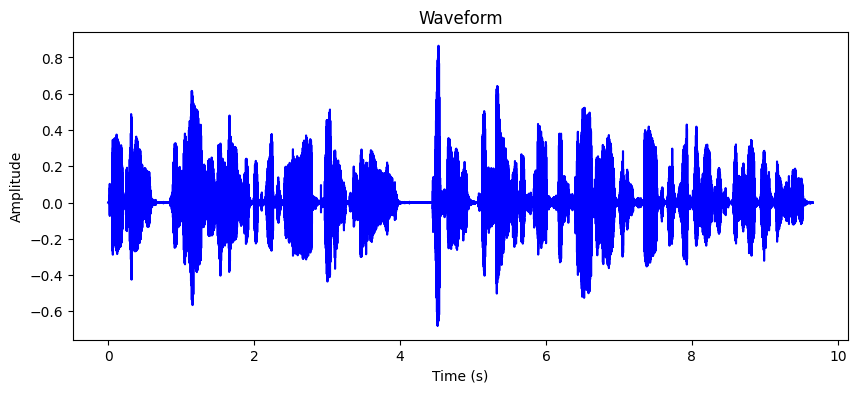

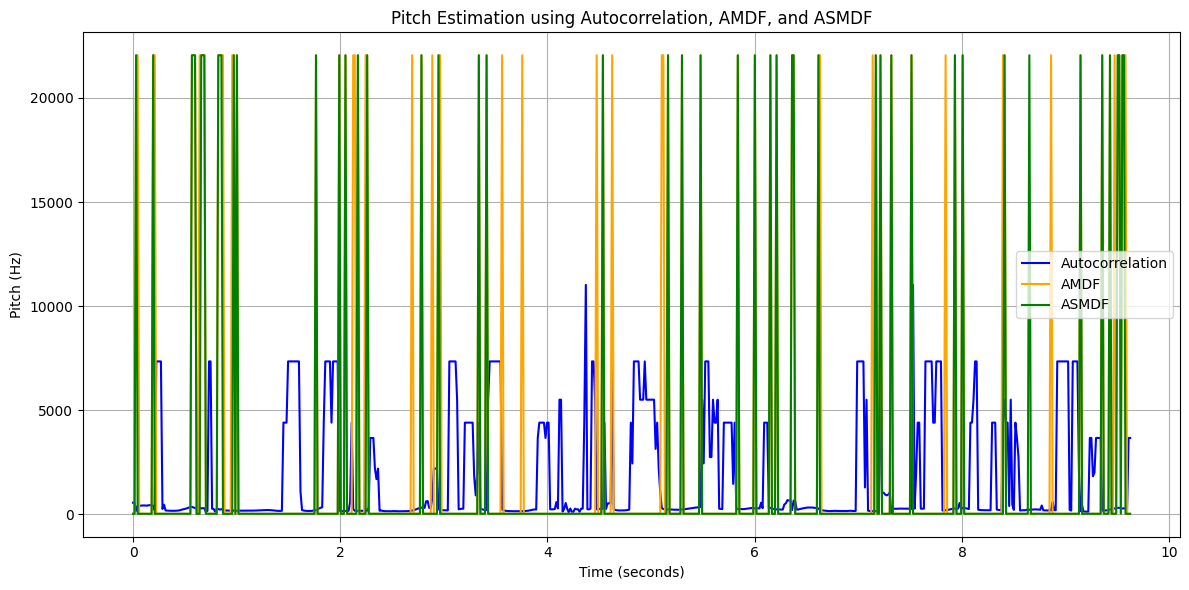

In [3]:
y, sr = librosa.load('/content/LJ001-0001.wav', sr=None)
samples = len(y)
dur = len(y)/sr

# Plotting waveform
time = np.linspace(0,dur, samples)
plt.figure(figsize=(10,4))
plt.plot(time,y,color='blue')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")
plt.show()

# Defining Frame
frame_duration = 0.03  # 30 ms
hop_duration = 0.015   # 15 ms
frame_length = int(frame_duration * sr)
hop_length = int(hop_duration * sr)


# Functions to estiate pitch of speech signal
def autocorrelation_pitch(frame, sr):
    corr = np.correlate(frame, frame, mode='full')
    corr = corr[len(corr)//2:]
    d = np.diff(corr)
    try:
        start = np.where(d > 0)[0][0]
        peak = np.argmax(corr[start:]) + start
        pitch = sr / peak if peak != 0 else 0
    except:
        pitch = 0
    return pitch

def amdf_pitch(frame, sr):
    lags = np.arange(1, len(frame))
    amdf = [np.mean(np.abs(frame[:-lag] - frame[lag:])) for lag in lags]
    pitch = sr / (np.argmin(amdf) + 1)
    return pitch

def asmdf_pitch(frame, sr):
    lags = np.arange(1, len(frame))
    asmdf = [np.mean((frame[:-lag] - frame[lag:])**2) for lag in lags]
    pitch = sr / (np.argmin(asmdf) + 1)
    return pitch

# --- APPLY TO ALL FRAMES ---
autocorr_pitches = []
amdf_pitches = []
asmdf_pitches = []
time_axis = []

for i in range(0, len(y) - frame_length, hop_length):
    frame = y[i:i + frame_length] * np.hamming(frame_length)
    autocorr_pitches.append(autocorrelation_pitch(frame, sr))
    amdf_pitches.append(amdf_pitch(frame, sr))
    asmdf_pitches.append(asmdf_pitch(frame, sr))
    time_axis.append(i / sr)

# --- PLOT THE PITCH ESTIMATES ---
plt.figure(figsize=(12, 6))
plt.plot(time_axis, autocorr_pitches, label='Autocorrelation', color='blue')
plt.plot(time_axis, amdf_pitches, label='AMDF', color='orange')
plt.plot(time_axis, asmdf_pitches, label='ASMDF', color='green')
plt.xlabel("Time (seconds)")
plt.ylabel("Pitch (Hz)")
plt.title("Pitch Estimation using Autocorrelation, AMDF, and ASMDF")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Part-2

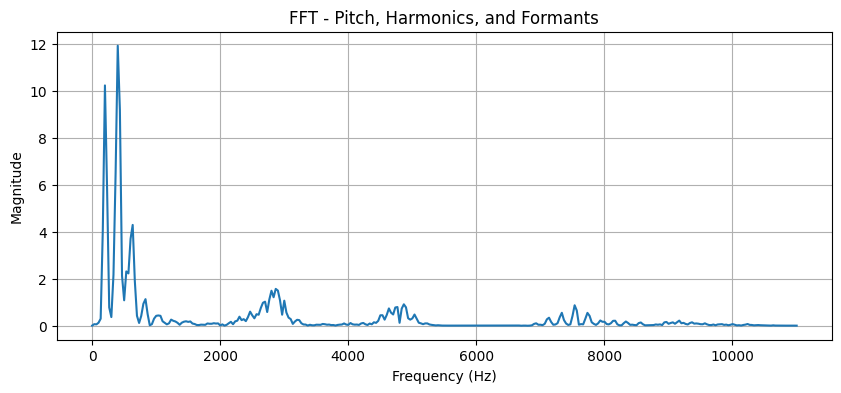

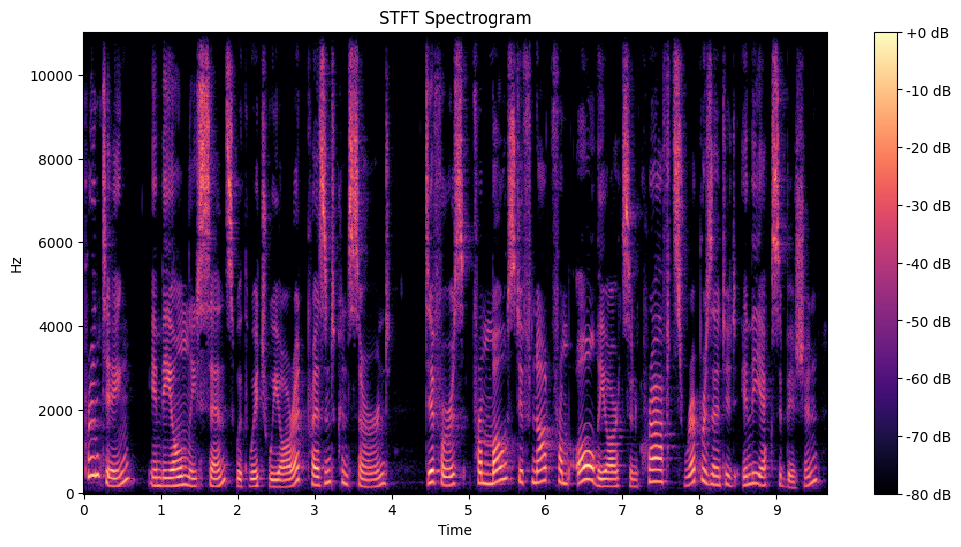

In [ ]:
# FFT to extract formants and harmonics
frame = y[10000:10000 + frame_length] * np.hamming(frame_length)
spectrum = np.fft.rfft(frame)
frequencies = np.fft.rfftfreq(len(frame), d=1/sr)

plt.figure(figsize=(10, 4))
plt.plot(frequencies, np.abs(spectrum))
plt.title("FFT - Pitch, Harmonics, and Formants")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.show()

# STFT for Spectrogram
D = librosa.stft(y, n_fft=1024, hop_length=hop_length)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure(figsize=(12, 6))
librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='hz')
plt.colorbar(format="%+2.0f dB")
plt.title("STFT Spectrogram")
plt.show()